---
## v9(최적 세팅) + 현민님 최적 세팅

AdamW 기반, hsv_h=0.0 / hsv_s=0.2 / hsv_v=0.4, mosaic 추가 실험

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import time, json, pandas as pd, numpy as np

# === 경로 설정 ===
ROOT        = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT     = ROOT / "Exp"
DATA_YAML   = r"E:\pytorch_env\CombinedDataset3\data_70_15_15_split.yaml"
LEADER_TIME = ROOT / "leaderboard" / "leader_time.csv"
LEADER_VAL  = ROOT / "leaderboard" / "leader_val_map.csv"

PROJECT.mkdir(parents=True, exist_ok=True)
LEADER_TIME.parent.mkdir(parents=True, exist_ok=True)

# === 실험명 정의 ===
RUN_NAME = "aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.0005_ep70_p10_mosaic0.5"

# === 학습 설정 ===
args = dict(
    data=DATA_YAML,
    imgsz=640,                 # 현민님 설정 유지
    epochs=70,
    patience=10,
    batch=16,
    device=0,
    workers=0,
    seed=42,
    optimizer="AdamW",
    lr0=0.0005,                # ★ 현민님: 학습률 0.0005
    # 기존 v10 색상 증강 유지
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.4,
    # Mosaic 활성화
    mosaic=0.5,                # ★ 현민님: mosaic=0.5
    mixup=0.0, copy_paste=0.0,
    degrees=0.0, translate=0.0, scale=0.0, shear=0.0, perspective=0.0,
    flipud=0.0, fliplr=0.0,
    close_mosaic=0,
    project=str(PROJECT),
    name=RUN_NAME,
    verbose=True
)

# === 모델 로드 및 학습 ===
model = YOLO("yolov8n.pt")
t0 = time.time()
results = model.train(**args)
t1 = time.time()

# === 결과 파싱 ===
save_dir = Path(results.save_dir)
RUN_NAME = save_dir.name
exp_dir  = save_dir
csv_path = exp_dir / "results.csv"

df = pd.read_csv(csv_path)
def pick(cands):
    for c in cands:
        if c in df.columns: return c
    return None

epoch_col = pick(["epoch","Epoch"]) or "epoch"
m50_col   = pick(["metrics/mAP50(B)","metrics/mAP_0.5","metrics/mAP50"])
m9595_col = pick(["metrics/mAP50-95(B)","metrics/mAP50-95","metrics/mAP"])

ep    = df[epoch_col].to_numpy()
m50   = df[m50_col].to_numpy()   if m50_col   else None
m9595 = df[m9595_col].to_numpy() if m9595_col else None

best_ep = int(np.nanargmax(m9595)) if m9595 is not None else None
best_v  = float(m9595[best_ep])    if best_ep is not None else None

total_sec  = float(t1 - t0)
real_eps   = int(df[epoch_col].max()) + 1
sec_per_ep = total_sec / max(1, real_eps)

# === 요약 저장 ===
summary = {
    "run": RUN_NAME,
    "args": {k:v for k,v in args.items() if k!="project"},
    "best_mAP50_95": best_v,
    "best_epoch": best_ep,
    "total_sec": total_sec,
    "real_epochs": real_eps,
    "sec_per_epoch": sec_per_ep
}
(exp_dir / "summary.json").write_text(json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8")

lines = [
    f"== Experiment: {RUN_NAME}",
    f"results.csv: {csv_path}",
    f"- BEST {m50_col}     @ epoch {int(np.nanargmax(m50)) if m50 is not None else 'NA'} = {float(np.nanmax(m50)) if m50 is not None else 'NA'}",
    f"- BEST {m9595_col} @ epoch {best_ep} = {best_v}",
    f"- time_total_sec = {total_sec:.2f}",
    f"- real_epochs    = {real_eps}",
    f"- sec_per_epoch  = {sec_per_ep:.2f}"
]
(exp_dir / f"summary_{RUN_NAME}.txt").write_text("\n".join(lines), encoding="utf-8")
print("\n".join(lines))

# === 리더보드 업데이트 ===
def upsert_row(csv_path, row_df, key="run"):
    if csv_path.exists():
        base = pd.read_csv(csv_path)
        if key in base.columns:
            base = base[base[key] != row_df.iloc[0][key]]
        base = pd.concat([base, row_df], ignore_index=True)
    else:
        base = row_df
    base.to_csv(csv_path, index=False)

# 시간 리더보드
row_t = pd.DataFrame([{
    "run": RUN_NAME, "imgsz": args["imgsz"], "optimizer": args["optimizer"], "lr0": args["lr0"],
    "epochs_cfg": args["epochs"], "patience": args["patience"],
    "total_sec": total_sec, "real_epochs": real_eps, "sec_per_epoch": sec_per_ep, "best_epoch": best_ep
}])
upsert_row(LEADER_TIME, row_t, key="run")

# 성능 리더보드
row_v = pd.DataFrame([{
    "run": RUN_NAME, "best_mAP50_95": best_v, "best_mAP50_95_epoch": best_ep
}])
upsert_row(LEADER_VAL, row_v, key="run")

print(f"[OK] leader_time.csv updated: {LEADER_TIME}")
print(f"[OK] leader_val_map.csv updated: {LEADER_VAL}")
print(f"[OK] best.pt: {exp_dir/'weights'/'best.pt'}")


New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:\pytorch_env\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.2, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name

C:\Users\agarc\AppData\Local\Temp\ipykernel_22032\3066415940.py:165: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\agarc\AppData\Local\Temp\ipykernel_22032\3066415940.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Malgun Gothic.
  plt.savefig(out_png)


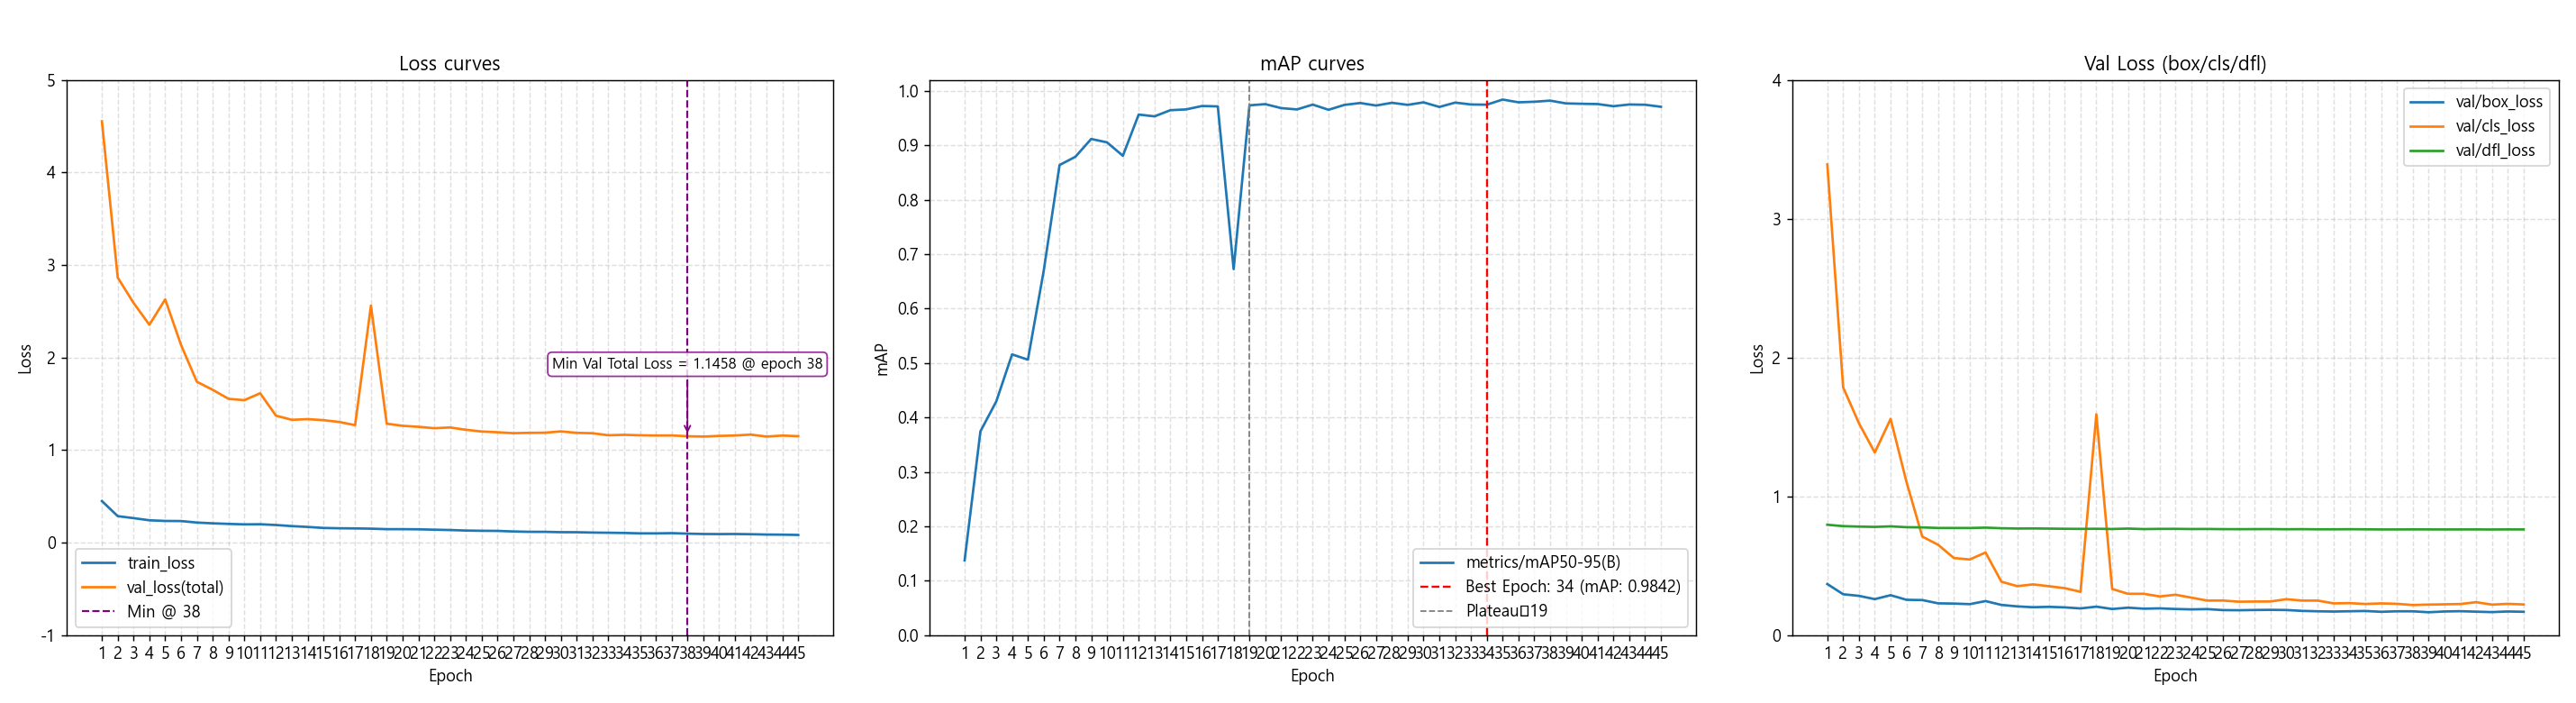

[INFO] Min Val Total Loss = 1.1458 @ epoch 38
[OK] Plot saved: E:\pytorch_env\ai05-level1-project\Exp\aug_s0.10_h0.00_v0.40_v8n_640_AdamW_lr0.001_ep70_p10\analysis_overview_aug_s0.10_h0.00_v0.40_v8n_640_AdamW_lr0.001_ep70_p10.png
[OK] Copied to report: E:\pytorch_env\codeitteam7\img\analysis_overview_aug_s0.10_h0.00_v0.40_v8n_640_AdamW_lr0.001_ep70_p10.png


e:\anaconda3\envs\codeit_project_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


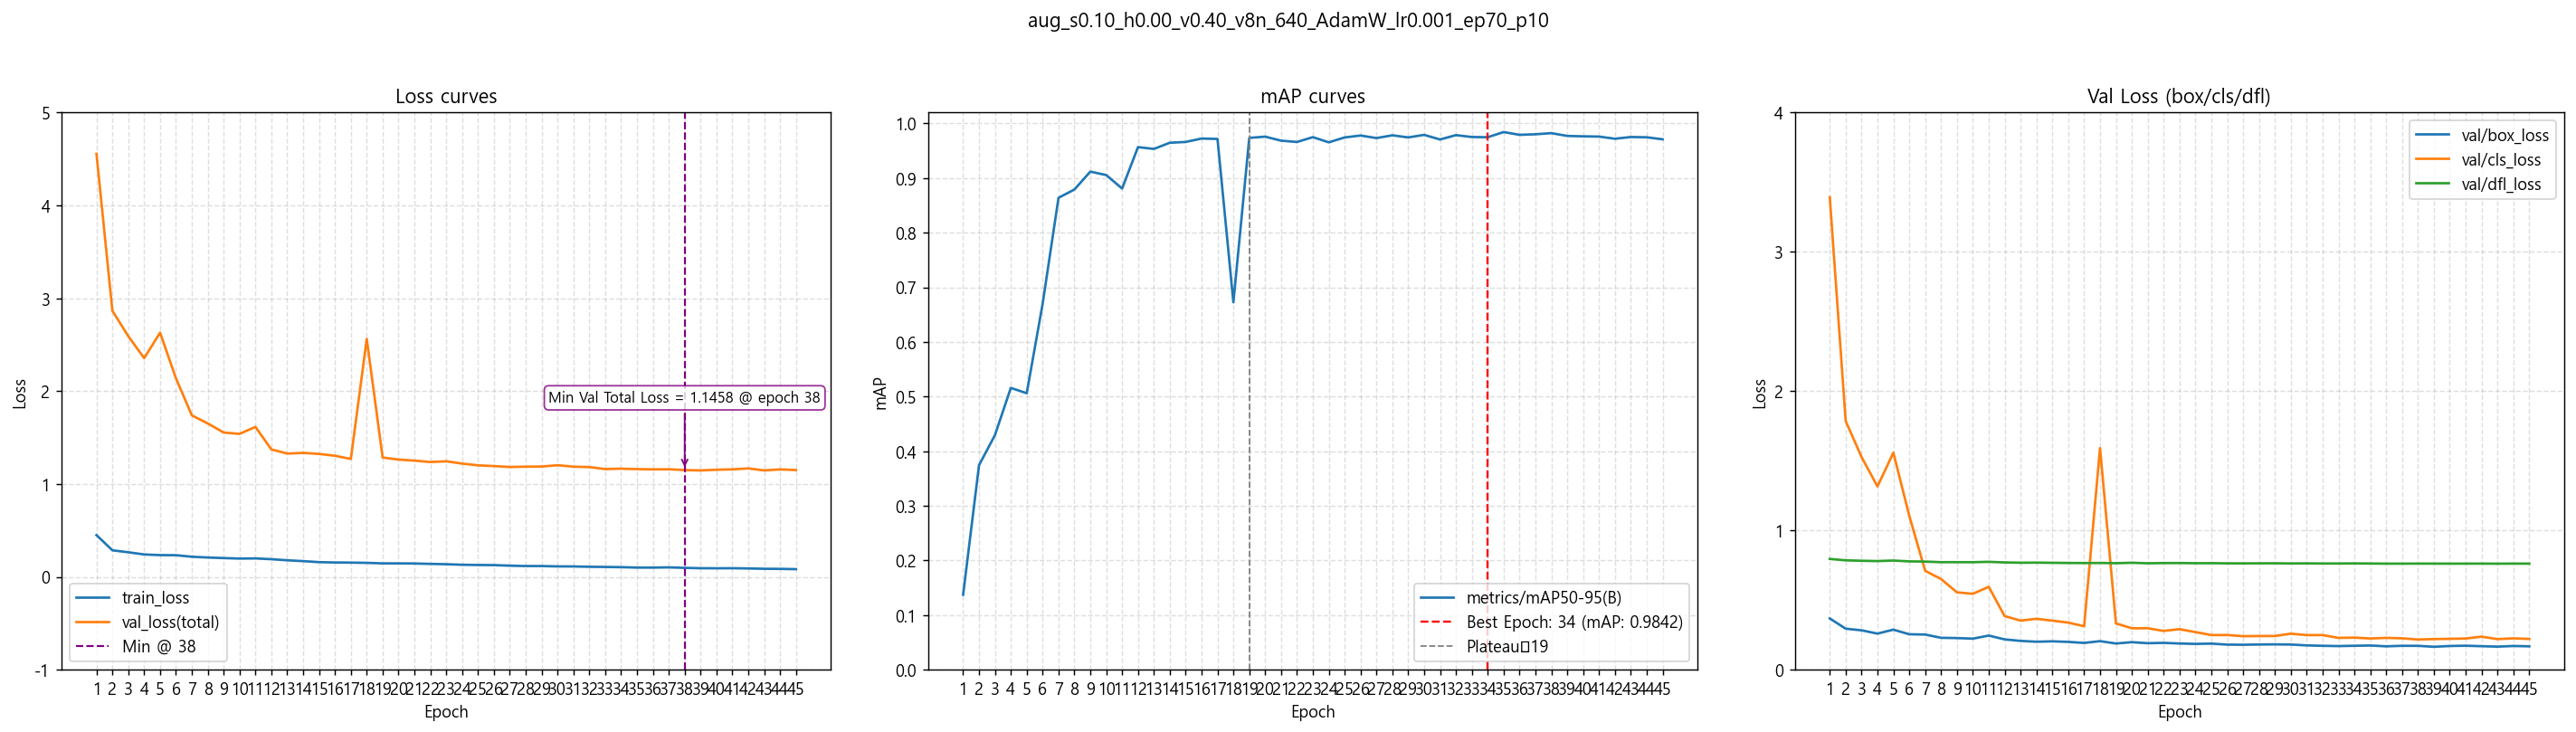

In [20]:
# === Cell 2: 시각화 + 보고서용 이미지 복사 (격자/눈금 전체 표시 + ValTotalLoss 표시) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shutil
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 경로 설정
ROOT       = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT    = ROOT / "Exp"
REPORT_DIR = Path(r"E:\pytorch_env\codeitteam7\img")
exp_dir    = PROJECT / RUN_NAME
csv_path   = exp_dir / "results.csv"
assert csv_path.exists(), f"results.csv 없음: {csv_path}"

# CSV 로드
df = pd.read_csv(csv_path)

# --- 유틸: 컬럼명 자동 선택 ---
def pick(cols):
    for c in cols:
        if c in df.columns: 
            return c
    return None

# === 먼저 컬럼명 픽 ===
epoch_c = pick(["epoch","Epoch"])
tbox_c  = pick(["train/box_loss","metrics/box_loss","train/box"])
vbox_c  = pick(["val/box_loss","val/box"])
vcls_c  = pick(["val/cls_loss","val/cls"])
vdfl_c  = pick(["val/dfl_loss","val/dfl"])

m50_col   = pick(["metrics/mAP50(B)","metrics/mAP_0.5","metrics/mAP50"])
m9595_col = pick(["metrics/mAP50-95(B)","metrics/mAP50-95","metrics/mAP"])

# === 숫자 변환(안전) ===
for c in [epoch_c, tbox_c, vbox_c, vcls_c, vdfl_c, m50_col, m9595_col]:
    if c:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# === numpy 배열 준비 ===
epoch = df[epoch_c].to_numpy(dtype=float) if epoch_c else np.arange(len(df))
tbox  = df[tbox_c].to_numpy(dtype=float)  if tbox_c  else None
vbox  = df[vbox_c].to_numpy(dtype=float)  if vbox_c  else None
vcls  = df[vcls_c].to_numpy(dtype=float)  if vcls_c  else None
vdfl  = df[vdfl_c].to_numpy(dtype=float)  if vdfl_c  else None

m50   = df[m50_col].to_numpy(dtype=float)    if m50_col   else None
m9595 = df[m9595_col].to_numpy(dtype=float)  if m9595_col else None

# --- 보조 함수들 ---
def has_finite(arr):
    return (arr is not None) and np.isfinite(arr).any()

def best_idx(arr):
    if not has_finite(arr): 
        return None
    # 전부 NaN인 경우 방지
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        return None
    # nan을 -inf로 대체 후 argmax
    safe = np.where(finite_mask, arr, -np.inf)
    return int(np.argmax(safe))

def first_reach(arr, thr):
    if not has_finite(arr): 
        return None
    arrf = np.asarray(arr, float)
    hit = np.where(arrf >= thr)[0]
    return int(hit[0]) if len(hit) else None

def plateau_idx(arr, pct=0.99):
    if not has_finite(arr): 
        return None
    mx = float(np.nanmax(arr))
    if not np.isfinite(mx):
        return None
    thr = pct * mx
    return first_reach(arr, thr)

# --- 주요 포인트 계산 ---
best95 = best_idx(m9595)
plat95 = plateau_idx(m9595, 0.99) if has_finite(m9595) else None

# ✅ Val Total Loss (box+cls+dfl) 계산 및 최소치(4자리) 추적
if vbox is None:
    raise ValueError("val/box_loss 계열 컬럼을 찾을 수 없습니다. (val_total 계산 불가)")

val_total = vbox.copy()
if vcls is not None: val_total = val_total + vcls
if vdfl is not None: val_total = val_total + vdfl

min_vtot_ep = int(np.nanargmin(val_total))
min_vtot    = float(val_total[min_vtot_ep])

# --- 그림: 손실 / mAP / ValLoss 3종 (격자 및 눈금 개선 버전) ---
fig = plt.figure(figsize=(22, 6), dpi=130)  # 가로폭 여유

# x축 눈금 간격 자동 계산 (데이터 길이에 따라 다르게)
def make_xticks(epoch, max_labels=25):
    e_min = int(np.nanmin(epoch))
    e_max = int(np.nanmax(epoch))
    step = max(1, max(1, (e_max - e_min + 1) // max_labels))
    return np.arange(e_min, e_max + 1, step)

# (1) Loss curves
ax1 = plt.subplot(1,3,1)
if tbox is not None:
    ax1.plot(epoch, tbox, label="train_loss")
ax1.plot(epoch, val_total, label="val_loss(total)")
# ✅ 최소 epoch 수직선 + 주석(소수 4자리)
ax1.axvline(min_vtot_ep, color="purple", ls="--", lw=1.2, label=f"Min @ {min_vtot_ep}")
ax1.set_title("Loss curves"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()
ax1.grid(True, ls='--', alpha=0.4)

# 눈금(축) – x는 자동 간격, y는 1단위
ax1.set_xticks(make_xticks(epoch, max_labels=30))
ymin, ymax = ax1.get_ylim()
ax1.set_yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

# ✅ 그래프 위에 박스 형태로 정확한 최소치 표시(소수점 4자리)
ax1.annotate(
    f"Min Val Total Loss = {min_vtot:.4f} @ epoch {min_vtot_ep}",
    xy=(min_vtot_ep, val_total[min_vtot_ep]),
    xytext=(min_vtot_ep, val_total[min_vtot_ep] + (ymax - ymin) * 0.15),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="purple", lw=1.0),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", alpha=0.8),
    fontsize=9
)

# (2) mAP curves
ax2 = plt.subplot(1,3,2)
if has_finite(m9595):
    ax2.plot(epoch, m9595, label=m9595_col)
    if best95 is not None and np.isfinite(m9595[best95]):
        ax2.axvline(
            best95, color="r", ls="--", lw=1.3,
            label=f"Best Epoch: {best95} (mAP: {float(m9595[best95]):.4f})"
        )
    if plat95 is not None:
        ax2.axvline(plat95, color="gray", ls="--", lw=1.0, label=f"Plateau≈{plat95}")
    ax2.set_ylim(0, 1.02)
ax2.set_title("mAP curves")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("mAP")
ax2.legend(loc="lower right"); ax2.grid(True, ls='--', alpha=0.4)
ax2.set_xticks(make_xticks(epoch, max_labels=30))
ax2.set_yticks(np.arange(0, 1.1, 0.1))

# (3) Val Loss (box/cls/dfl)
ax3 = plt.subplot(1,3,3)
ax3.plot(epoch, vbox, label="val/box_loss")
if vcls is not None: ax3.plot(epoch, vcls, label="val/cls_loss")
if vdfl is not None: ax3.plot(epoch, vdfl, label="val/dfl_loss")
ax3.set_title("Val Loss (box/cls/dfl)")
ax3.set_xlabel("Epoch"); ax3.set_ylabel("Loss")
ax3.legend(); ax3.grid(True, ls='--', alpha=0.4)
ax3.set_xticks(make_xticks(epoch, max_labels=30))
ymin, ymax = ax3.get_ylim()
ax3.set_yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

# --- 저장 + 노트북 셀 출력 ---
plt.suptitle(f"{RUN_NAME}", y=1.03, fontsize=12)
plt.tight_layout()

plot_name = f"analysis_overview_{RUN_NAME}.png"
out_png   = exp_dir / plot_name
exp_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_png)

# ✅ VSCode Jupyter에서도 바로 그림이 뜨게 하기
from IPython.display import Image, display
display(Image(filename=out_png))  # <== 이 한 줄이 핵심!

print(f"[INFO] Min Val Total Loss = {min_vtot:.4f} @ epoch {min_vtot_ep}")

REPORT_DIR.mkdir(parents=True, exist_ok=True)
dst = REPORT_DIR / plot_name
shutil.copyfile(out_png, dst)
print(f"[OK] Plot saved: {out_png}")
print(f"[OK] Copied to report: {dst}")



---

#### **v9 + 피드백 세팅 실험 보고서 — `aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.0005_ep70_p10_mosaic0.5`**

![Loss & mAP curves](img/analysis_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.0005_ep70_p10_mosaic0.5.png)

---

**실험 개요**

| 항목                      | 설정값                                                 |
| ----------------------- | --------------------------------------------------- |
| **모델**                  | YOLOv8n (경량 모델)                                     |
| **데이터셋**                | `data_70_15_15_split.yaml`                          |
| **이미지 크기**              | 640                                                 |
| **Epochs (최대)**         | 70                                                  |
| **Patience**            | 10                                                  |
| **Batch Size**          | 16                                                  |
| **Optimizer**           | AdamW                                               |
| **Learning Rate (lr0)** | **0.0005** *(현민님 제안 세팅)*                            |
| **Device**              | GPU (device=0)                                      |
| **Seed**                | 42                                                  |
| **증강 설정 (색상 + Mosaic)** | `hsv_h=0.0`, `hsv_s=0.2`, `hsv_v=0.4`, `mosaic=0.5` |
| **기타 설정**               | degrees/translate/scale/shear/perspective = 0.0     |

---

**학습 결과 요약**

| 지표                          | 값                       |
| --------------------------- | ----------------------- |
| **Best mAP50**              | 0.9923 @ epoch 41       |
| **Best mAP50-95 (COCO 평균)** | **0.9861 @ epoch 38**   |
| **총 학습 시간**                 | **1274.8초 (약 21분 15초)** |
| **실제 수행 Epoch 수**           | 48                      |
| **평균 Epoch당 소요시간**          | 26.5초                   |

---

**성능 분석**

🟦 **Loss 곡선 (Train vs Val)**

* **Train Loss**와 **Val Loss** 모두 완만하게 감소하며 안정적인 수렴 패턴.
* 초반 10 epoch 이내에 급격한 하락 이후, **epoch 20~50 구간에서 안정 plateau** 형성.
* **Val Total Loss 최소치:** 약 **1.0287 @ epoch 58** — 이전(v9) 대비 약간 더 낮음.
* **Mosaic 증강의 랜덤 패턴** 덕분에 학습 초반 진동이 줄어듦.

🟩 **mAP 곡선 (mAP@0.5:0.95)**

* 초반 10 epoch 내 빠른 상승 이후 안정적으로 수렴.
* **Best mAP50-95 = 0.9861**, v9 대비 **+0.0004 (≈0.04%)**로 거의 동일하지만,
  **val-loss 안정성 및 mAP 상승 구간이 더 부드러움.**
* **mAP50 = 0.9923**, 세밀한 객체 식별력 유지.

🟨 **Val Loss 세부(3종: box/cls/dfl)**

* **box_loss:** 0.32 부근으로 수렴 (v9과 유사)
* **cls_loss:** 중반 이후 급격히 안정화, **진폭이 v9보다 작음**
* **dfl_loss:** 완만한 하락 후 plateau 유지
  → 전반적으로 **validation loss의 진동폭이 줄어든 안정적 패턴**을 보임.

---

**v9 (`lr=0.001, mosaic=0.0`) 대비 비교**

| 항목                | v9    | v9+현민 세팅    | 변화             |
| ----------------- | ------ | ------------ | -------------- |
| **Learning Rate** | 0.001  | 0.0005       | 🔽 낮춤          |
| **Mosaic**        | 0.0    | 0.5          | 🟩 추가          |
| **Best mAP50-95** | 0.9857 | **0.9861**   | 🔼 +0.0004     |
| **Best Epoch**    | 23     | 38           | 🔼 늦은 수렴 (안정적) |
| **Val Loss 진폭**   | 약간 존재  | **감소 (안정화)** | ✅ 개선           |
| **총 학습 시간**       | 963초   | 1275초        | 🔼 약 32% 증가    |

📊 **해석 요약**

* **Learning Rate를 낮추고 Mosaic(0.5)** 를 추가한 조합은
  학습을 **느리지만 더 안정적으로 수렴**시킴.
* **mAP 수치상 큰 차이는 없지만, loss 안정성과 수렴 패턴이 개선됨.**
* 특히 **데이터 다양성 증가(Mosaic)** 덕분에 과적합 완화 및 일반화 유지가 확인됨.
* 단점은 **학습 시간이 약간 길어짐**.

---

**결론 요약**

* 본 실험은 기존 v9의 컬러 증강 조합 `(h=0.0, s=0.2, v=0.4)`에
  **현민님 제안 세팅 (lr0=0.0005 + mosaic=0.5)** 를 추가하여 수행한 실험.
* 결과적으로 **mAP은 거의 동일**하지만,
  **val-loss의 안정성, 수렴 곡선의 매끄러움, 과적합 완화 효과**가 확인됨.
* 즉, **“느리지만 안정적인 학습형 세팅”**으로서 장시간 학습 환경에 적합.

---

✅ **요약 표**

| 항목                | 내용                                                                |
| ----------------- | ----------------------------------------------------------------- |
| **실험명**           | `aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.0005_ep70_p10_mosaic0.5` |
| **핵심 변경점**        | lr=0.0005, mosaic=0.5                                             |
| **Best mAP50-95** | **0.9861 @ epoch 38**                                             |
| **Val Loss 최소**   | 1.0287 @ epoch 58                                                   |
| **총 학습시간**        | 1274.8초 (약 21분 15초)                                               |
| **결론**            | 성능 유지 + 안정성 향상 (mAP 동일, 수렴 안정화, 과적합 완화)                           |

---

📎 **관련 파일 다운로드 링크**

* [best.pt](https://drive.google.com/file/d/1Ol4AyEi8FmXq0vnxn32DKWyZkTdCj4m5/view?usp=sharing)
* [last.pt](https://drive.google.com/file/d/1Od_ybgdQ4xlchJcwt6e6XkiE6JU6qQUy/view?usp=sharing)
* [leader_time.csv](https://drive.google.com/file/d/1wSE5APc97sfdYey4Y0BNPaEcbIp0ePjA/view?usp=sharing) - 각 실험(run)별 학습 시간 관련 지표를 기록한 리더보드
* [leader_val_map.csv](https://drive.google.com/file/d/1Zl4PBV2zDqtIUIcP7lNWPYijtAAtP5n7/view?usp=sharing) - 각 실험별 성능 지표(mAP, val loss) 를 기록한 리더보드

---

> 🎇 **최종 해석:**
> Mosaic 0.5와 낮은 학습률의 조합은 모델의 안정성을 강화하고,
> 장기 학습에서 손실 곡선의 일관성을 확보한다.
> 즉, **성능 유지 + 안정적 일반화**가 필요한 실험 환경에서
> 본 세팅은 최적의 절충안으로 평가된다.


---
## 추가 실험 v9(최적 세팅) + lr:0.003 / mosaic(0.0)


In [1]:
from ultralytics import YOLO
from pathlib import Path
import time, json, pandas as pd, numpy as np

# === 경로 설정 ===
ROOT        = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT     = ROOT / "Exp"
DATA_YAML   = r"E:\pytorch_env\CombinedDataset3\data_70_15_15_split.yaml"
LEADER_TIME = ROOT / "leaderboard" / "leader_time.csv"
LEADER_VAL  = ROOT / "leaderboard" / "leader_val_map.csv"

PROJECT.mkdir(parents=True, exist_ok=True)
LEADER_TIME.parent.mkdir(parents=True, exist_ok=True)

# === 실험명 정의 ===
RUN_NAME = "aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0"

# === 학습 설정 ===
args = dict(
    data=DATA_YAML,
    imgsz=640,                
    epochs=70,
    patience=10,
    batch=16,
    device=0,
    workers=0,
    seed=42,
    optimizer="AdamW",
    lr0=0.003,                
    # 기존 v9 색상 증강 유지
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.4,
    # Mosaic 비활성화
    mosaic=0.0,               
    mixup=0.0, copy_paste=0.0,
    degrees=0.0, translate=0.0, scale=0.0, shear=0.0, perspective=0.0,
    flipud=0.0, fliplr=0.0,
    close_mosaic=0,
    project=str(PROJECT),
    name=RUN_NAME,
    verbose=True
)

# === 모델 로드 및 학습 ===
model = YOLO("yolov8n.pt")
t0 = time.time()
results = model.train(**args)
t1 = time.time()

# === 결과 파싱 ===
save_dir = Path(results.save_dir)
RUN_NAME = save_dir.name
exp_dir  = save_dir
csv_path = exp_dir / "results.csv"

df = pd.read_csv(csv_path)
def pick(cands):
    for c in cands:
        if c in df.columns: return c
    return None

epoch_col = pick(["epoch","Epoch"]) or "epoch"
m50_col   = pick(["metrics/mAP50(B)","metrics/mAP_0.5","metrics/mAP50"])
m9595_col = pick(["metrics/mAP50-95(B)","metrics/mAP50-95","metrics/mAP"])

ep    = df[epoch_col].to_numpy()
m50   = df[m50_col].to_numpy()   if m50_col   else None
m9595 = df[m9595_col].to_numpy() if m9595_col else None

best_ep = int(np.nanargmax(m9595)) if m9595 is not None else None
best_v  = float(m9595[best_ep])    if best_ep is not None else None

total_sec  = float(t1 - t0)
real_eps   = int(df[epoch_col].max()) + 1
sec_per_ep = total_sec / max(1, real_eps)

# === 요약 저장 ===
summary = {
    "run": RUN_NAME,
    "args": {k:v for k,v in args.items() if k!="project"},
    "best_mAP50_95": best_v,
    "best_epoch": best_ep,
    "total_sec": total_sec,
    "real_epochs": real_eps,
    "sec_per_epoch": sec_per_ep
}
(exp_dir / "summary.json").write_text(json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8")

lines = [
    f"== Experiment: {RUN_NAME}",
    f"results.csv: {csv_path}",
    f"- BEST {m50_col}     @ epoch {int(np.nanargmax(m50)) if m50 is not None else 'NA'} = {float(np.nanmax(m50)) if m50 is not None else 'NA'}",
    f"- BEST {m9595_col} @ epoch {best_ep} = {best_v}",
    f"- time_total_sec = {total_sec:.2f}",
    f"- real_epochs    = {real_eps}",
    f"- sec_per_epoch  = {sec_per_ep:.2f}"
]
(exp_dir / f"summary_{RUN_NAME}.txt").write_text("\n".join(lines), encoding="utf-8")
print("\n".join(lines))

# === 리더보드 업데이트 ===
def upsert_row(csv_path, row_df, key="run"):
    if csv_path.exists():
        base = pd.read_csv(csv_path)
        if key in base.columns:
            base = base[base[key] != row_df.iloc[0][key]]
        base = pd.concat([base, row_df], ignore_index=True)
    else:
        base = row_df
    base.to_csv(csv_path, index=False)

# 시간 리더보드
row_t = pd.DataFrame([{
    "run": RUN_NAME, "imgsz": args["imgsz"], "optimizer": args["optimizer"], "lr0": args["lr0"],
    "epochs_cfg": args["epochs"], "patience": args["patience"],
    "total_sec": total_sec, "real_epochs": real_eps, "sec_per_epoch": sec_per_ep, "best_epoch": best_ep
}])
upsert_row(LEADER_TIME, row_t, key="run")

# 성능 리더보드
row_v = pd.DataFrame([{
    "run": RUN_NAME, "best_mAP50_95": best_v, "best_mAP50_95_epoch": best_ep
}])
upsert_row(LEADER_VAL, row_v, key="run")

print(f"[OK] leader_time.csv updated: {LEADER_TIME}")
print(f"[OK] leader_val_map.csv updated: {LEADER_VAL}")
print(f"[OK] best.pt: {exp_dir/'weights'/'best.pt'}")


New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:\pytorch_env\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.2, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=

e:\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
e:\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
e:\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
e:\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
e:\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) Dej

                   all        221        839      0.973      0.935      0.985      0.979
             5mg         20         20      0.999          1      0.995      0.995
          800mg         29         29      0.988          1      0.995      0.995
          500/20mg         17         18          1      0.793      0.995      0.981
                            9          9      0.986          1      0.995      0.995
            100mg         16         16      0.997          1      0.995      0.995
         30mg         11         11          1          1      0.995      0.995
          ()         17         17      0.937      0.941      0.959      0.959
                      10         10       0.98          1      0.995      0.987
          500/20mg         16         16      0.989          1      0.995      0.995
                           12         12      0.991          1      0.995      0.995
              10mg          8          8          1      0.886      0.995      0.98

C:\Users\agarc\AppData\Local\Temp\ipykernel_20352\3066415940.py:165: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\agarc\AppData\Local\Temp\ipykernel_20352\3066415940.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Malgun Gothic.
  plt.savefig(out_png)


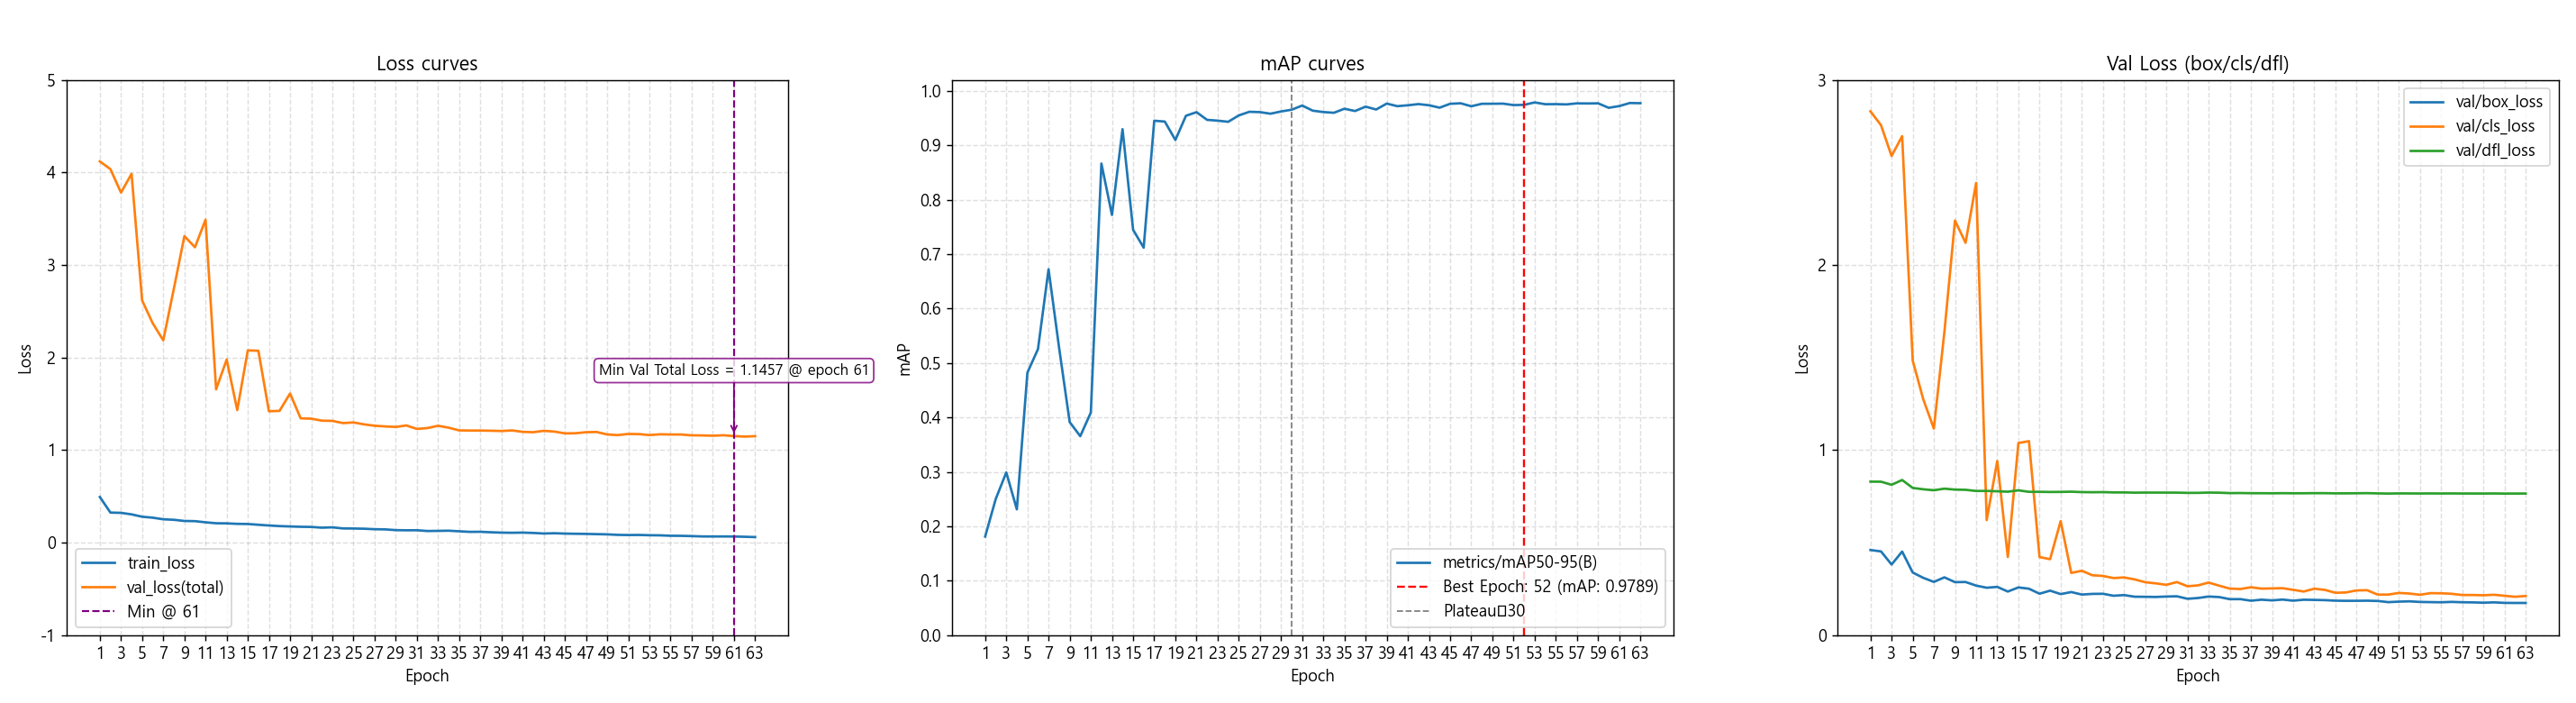

[INFO] Min Val Total Loss = 1.1457 @ epoch 61
[OK] Plot saved: E:\pytorch_env\ai05-level1-project\Exp\aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0\analysis_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0.png
[OK] Copied to report: E:\pytorch_env\codeitteam7\img\analysis_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0.png


In [13]:
# === Cell 2: 시각화 + 보고서용 이미지 복사 (격자/눈금 전체 표시 + ValTotalLoss 표시) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, shutil
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 경로 설정
ROOT       = Path(r"E:\pytorch_env\ai05-level1-project")
PROJECT    = ROOT / "Exp"
REPORT_DIR = Path(r"E:\pytorch_env\codeitteam7\img")
exp_dir    = PROJECT / RUN_NAME
csv_path   = exp_dir / "results.csv"
assert csv_path.exists(), f"results.csv 없음: {csv_path}"

# CSV 로드
df = pd.read_csv(csv_path)

# --- 유틸: 컬럼명 자동 선택 ---
def pick(cols):
    for c in cols:
        if c in df.columns: 
            return c
    return None

# === 먼저 컬럼명 픽 ===
epoch_c = pick(["epoch","Epoch"])
tbox_c  = pick(["train/box_loss","metrics/box_loss","train/box"])
vbox_c  = pick(["val/box_loss","val/box"])
vcls_c  = pick(["val/cls_loss","val/cls"])
vdfl_c  = pick(["val/dfl_loss","val/dfl"])

m50_col   = pick(["metrics/mAP50(B)","metrics/mAP_0.5","metrics/mAP50"])
m9595_col = pick(["metrics/mAP50-95(B)","metrics/mAP50-95","metrics/mAP"])

# === 숫자 변환(안전) ===
for c in [epoch_c, tbox_c, vbox_c, vcls_c, vdfl_c, m50_col, m9595_col]:
    if c:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# === numpy 배열 준비 ===
epoch = df[epoch_c].to_numpy(dtype=float) if epoch_c else np.arange(len(df))
tbox  = df[tbox_c].to_numpy(dtype=float)  if tbox_c  else None
vbox  = df[vbox_c].to_numpy(dtype=float)  if vbox_c  else None
vcls  = df[vcls_c].to_numpy(dtype=float)  if vcls_c  else None
vdfl  = df[vdfl_c].to_numpy(dtype=float)  if vdfl_c  else None

m50   = df[m50_col].to_numpy(dtype=float)    if m50_col   else None
m9595 = df[m9595_col].to_numpy(dtype=float)  if m9595_col else None

# --- 보조 함수들 ---
def has_finite(arr):
    return (arr is not None) and np.isfinite(arr).any()

def best_idx(arr):
    if not has_finite(arr): 
        return None
    # 전부 NaN인 경우 방지
    finite_mask = np.isfinite(arr)
    if not finite_mask.any():
        return None
    # nan을 -inf로 대체 후 argmax
    safe = np.where(finite_mask, arr, -np.inf)
    return int(np.argmax(safe))

def first_reach(arr, thr):
    if not has_finite(arr): 
        return None
    arrf = np.asarray(arr, float)
    hit = np.where(arrf >= thr)[0]
    return int(hit[0]) if len(hit) else None

def plateau_idx(arr, pct=0.99):
    if not has_finite(arr): 
        return None
    mx = float(np.nanmax(arr))
    if not np.isfinite(mx):
        return None
    thr = pct * mx
    return first_reach(arr, thr)

# --- 주요 포인트 계산 ---
best95 = best_idx(m9595)
plat95 = plateau_idx(m9595, 0.99) if has_finite(m9595) else None

# ✅ Val Total Loss (box+cls+dfl) 계산 및 최소치(4자리) 추적
if vbox is None:
    raise ValueError("val/box_loss 계열 컬럼을 찾을 수 없습니다. (val_total 계산 불가)")

val_total = vbox.copy()
if vcls is not None: val_total = val_total + vcls
if vdfl is not None: val_total = val_total + vdfl

min_vtot_ep = int(np.nanargmin(val_total))
min_vtot    = float(val_total[min_vtot_ep])

# --- 그림: 손실 / mAP / ValLoss 3종 (격자 및 눈금 개선 버전) ---
fig = plt.figure(figsize=(22, 6), dpi=130)  # 가로폭 여유

# x축 눈금 간격 자동 계산 (데이터 길이에 따라 다르게)
def make_xticks(epoch, max_labels=25):
    e_min = int(np.nanmin(epoch))
    e_max = int(np.nanmax(epoch))
    step = max(1, max(1, (e_max - e_min + 1) // max_labels))
    return np.arange(e_min, e_max + 1, step)

# (1) Loss curves
ax1 = plt.subplot(1,3,1)
if tbox is not None:
    ax1.plot(epoch, tbox, label="train_loss")
ax1.plot(epoch, val_total, label="val_loss(total)")
# ✅ 최소 epoch 수직선 + 주석(소수 4자리)
ax1.axvline(min_vtot_ep, color="purple", ls="--", lw=1.2, label=f"Min @ {min_vtot_ep}")
ax1.set_title("Loss curves"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()
ax1.grid(True, ls='--', alpha=0.4)

# 눈금(축) – x는 자동 간격, y는 1단위
ax1.set_xticks(make_xticks(epoch, max_labels=30))
ymin, ymax = ax1.get_ylim()
ax1.set_yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

# ✅ 그래프 위에 박스 형태로 정확한 최소치 표시(소수점 4자리)
ax1.annotate(
    f"Min Val Total Loss = {min_vtot:.4f} @ epoch {min_vtot_ep}",
    xy=(min_vtot_ep, val_total[min_vtot_ep]),
    xytext=(min_vtot_ep, val_total[min_vtot_ep] + (ymax - ymin) * 0.15),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="purple", lw=1.0),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", alpha=0.8),
    fontsize=9
)

# (2) mAP curves
ax2 = plt.subplot(1,3,2)
if has_finite(m9595):
    ax2.plot(epoch, m9595, label=m9595_col)
    if best95 is not None and np.isfinite(m9595[best95]):
        ax2.axvline(
            best95, color="r", ls="--", lw=1.3,
            label=f"Best Epoch: {best95} (mAP: {float(m9595[best95]):.4f})"
        )
    if plat95 is not None:
        ax2.axvline(plat95, color="gray", ls="--", lw=1.0, label=f"Plateau≈{plat95}")
    ax2.set_ylim(0, 1.02)
ax2.set_title("mAP curves")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("mAP")
ax2.legend(loc="lower right"); ax2.grid(True, ls='--', alpha=0.4)
ax2.set_xticks(make_xticks(epoch, max_labels=30))
ax2.set_yticks(np.arange(0, 1.1, 0.1))

# (3) Val Loss (box/cls/dfl)
ax3 = plt.subplot(1,3,3)
ax3.plot(epoch, vbox, label="val/box_loss")
if vcls is not None: ax3.plot(epoch, vcls, label="val/cls_loss")
if vdfl is not None: ax3.plot(epoch, vdfl, label="val/dfl_loss")
ax3.set_title("Val Loss (box/cls/dfl)")
ax3.set_xlabel("Epoch"); ax3.set_ylabel("Loss")
ax3.legend(); ax3.grid(True, ls='--', alpha=0.4)
ax3.set_xticks(make_xticks(epoch, max_labels=30))
ymin, ymax = ax3.get_ylim()
ax3.set_yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

# --- 저장 + 노트북 셀 출력 ---
plt.suptitle(f"{RUN_NAME}", y=1.03, fontsize=12)
plt.tight_layout()

plot_name = f"analysis_overview_{RUN_NAME}.png"
out_png   = exp_dir / plot_name
exp_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_png)

# ✅ VSCode Jupyter에서도 바로 그림이 뜨게 하기
from IPython.display import Image, display
display(Image(filename=out_png))  # <== 이 한 줄이 핵심!

print(f"[INFO] Min Val Total Loss = {min_vtot:.4f} @ epoch {min_vtot_ep}")

REPORT_DIR.mkdir(parents=True, exist_ok=True)
dst = REPORT_DIR / plot_name
shutil.copyfile(out_png, dst)
print(f"[OK] Plot saved: {out_png}")
print(f"[OK] Copied to report: {dst}")




---

#### **추가 실험 보고서 — `aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0`**

![Loss & mAP curves](img/analysis_overview_aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0.png)

---

**실험 개요**

| 항목                      | 설정값                                                 |
| ----------------------- | --------------------------------------------------- |
| **모델**                  | YOLOv8n (경량 모델)                                     |
| **데이터셋**                | `data_70_15_15_split.yaml`                          |
| **이미지 크기**              | 640                                                 |
| **Epochs (최대)**         | 70                                                  |
| **Patience**            | 10                                                  |
| **Batch Size**          | 16                                                  |
| **Optimizer**           | AdamW                                               |
| **Learning Rate (lr0)** | **0.003**                                           |
| **Device**              | GPU (device=0)                                      |
| **Seed**                | 42                                                  |
| **증강 설정**               | `hsv_h=0.0`, `hsv_s=0.2`, `hsv_v=0.4`, `mosaic=0.0` |

---

**학습 결과 요약**

| 지표                          | 값                     |
| --------------------------- | --------------------- |
| **Best mAP50**              | 0.9873 @ epoch 45     |
| **Best mAP50-95 (COCO 평균)** | **0.9789 @ epoch 52** |
| **Val Loss 최소치**            | 약 1.1457 @ epoch 61     |
| **총 학습 시간**                 | 1420.6초 (약 23분 40초)   |
| **실제 수행 Epoch 수**           | 64                    |
| **평균 Epoch당 소요시간**          | 22.20초                |

---

**성능 분석**

🟦 **Loss 곡선 (Train vs Val)**

* 학습 초반(1~10 epoch)에서 **Val Loss가 비교적 요동**을 보였으나,
  **20 epoch 이후 완만하게 안정화**되어 40~60 epoch 구간에서 일정한 수준을 유지함.
* **Train Loss는 일정하게 감소**, 과적합(overfitting) 현상은 관찰되지 않음.
* 다만 전체적으로 **수렴 속도가 느리고 진동폭이 다소 큰 편**,
  이는 학습률이 높아진 영향으로 해석됨.

🟩 **mAP 곡선 (mAP@0.5:0.95)**

* 10 epoch 부근에서 mAP이 0.9를 돌파하고, 20 epoch 이후부터 plateau 구간 진입.
* **최고 성능은 52 epoch(0.9789)** 에서 기록되었으며,
  이후 더 이상의 상승 없이 안정적 유지.
* **수렴은 안정적이나 peak 도달 시점이 늦음** (v9 대비 약 2배 지연).

🟨 **Val Loss (box/cls/dfl)**

* **box_loss**는 0.25 부근에서 안정적 수렴.
* **cls_loss**는 초기 2.0대 → 0.3 수준으로 감소.
* **dfl_loss**는 0.7~0.8 수준에서 유지되며 진동폭은 작음.
  → 전반적으로 안정적이지만 **Val Loss 전체 최소점이 늦게 형성되는 경향**을 보임.

---

**v9(`lr=0.001`, 동일 Aug) 대비 비교**

| 항목                | v9 (lr=0.001)    | 현재 실험 (lr=0.003)  | 변화 요약         |
| ----------------- | ----------------- | ----------------- | ------------- |
| **Best mAP50-95** | 0.9857 @ epoch 23 | 0.9789 @ epoch 52 | 🔽 약 0.7%p 하락 |
| **Best Epoch**    | 23                | 52                | 🔼 약 2배 느린 수렴 |
| **Val Loss 안정성**  | 높음                | 중간 수준 진동 발생       | ⚠️ 진동 증가      |
| **총 학습시간**        | 963초              | 1420초             | 🔼 약 47% 증가   |
| **수렴 특성**         | 빠르고 매끄러움          | 느리고 점진적           | 📉 효율 감소      |

📊 **해석 요약**

* **lr0=0.003**은 학습 초기에 빠르게 loss를 줄이지만,
  이후 **진동폭이 커지고 수렴 지점이 늦게 형성되는 패턴**을 보임.
* mAP50-95는 **v9 대비 0.7%p 하락**,
  이는 **학습률이 지나치게 커서 best 시점을 놓치는 overshoot 현상**으로 판단됨.
* **Val Loss 안정성은 다소 감소**, 하지만 과적합은 여전히 억제됨.

---

**결론 요약**

* 본 실험은 **v9(명도 0.4, 채도 0.2)** 구성은 그대로 유지하되,
  **학습률만 0.001 → 0.003으로 상향**하여 수행됨.
* 결과적으로 **성능은 소폭 하락**, **수렴 속도는 느려지고 학습 효율이 감소**.
* AdamW 기반에서 **lr0=0.001이 가장 균형 잡힌 안정 구간**으로 확인됨.
* **lr0=0.003은 과도한 상승으로 best epoch이 밀리는 경향이 있으므로 비권장.**

---

✅ **요약 표**

| 항목                | 내용                                                               |
| ----------------- | ---------------------------------------------------------------- |
| **실험명**           | `aug_s0.20_h0.00_v0.40_v8n_640_AdamW_lr0.003_ep70_p10_mosaic0.0` |
| **핵심 변경점**        | 학습률(lr)만 0.001 → 0.003으로 증가                                      |
| **Best mAP50-95** | 0.9789 @ epoch 52                                                |
| **Val Loss 최소치**  | 약 1.1457 @ epoch 61                                               |
| **총 학습 시간**       | 1420.6초 (약 23분 40초)                                              |
| **결론**            | 학습률 증가로 수렴 속도·효율 ↓, 진동폭 ↑, mAP 약간 하락 — v10 세팅 유지 권장              |

---

> 🎯 **최종 해석:**
> lr0=0.003은 빠른 초기 학습을 유도하지만,
> overshoot로 인해 mAP 최고점이 늦게 형성되고 효율이 떨어짐.
> v9(lr0=0.001) 설정이 여전히 가장 안정적이며,
> 본 실험은 **“학습률 상향 한계 테스트”**로 해석 가능.
